## Finite Element Method
#### to solve Acid Mediated Tumor Growth Model
this notebook shows how solve the radially symmetric version of tumor invasion model that describes relation between :
- Population of normal cells    $N_n(r,t)$
- Population of tumor cells    $N_t(r,t)$
- Concentration of excess $H^+$ ions    $C_h(r,t)$
---

## Gatenby-Gawlinski tumor invasion mathmatical Model
$$
\frac{\partial N_n}{\partial t} = r_{n1} N_n \left( 1 - \frac{N_n}{K_n} \right) - r_{n2} C_h N_n,\ \ \ \ (1)
$$

$$
\frac{\partial N_t}{\partial t} = r_{t1} N_t \left( 1 - \frac{N_t}{K_t} \right)
+ \frac{1}{r^2} \frac{\partial}{\partial r} \left[ r^2 D(N_n) \frac{\partial N_t}{\partial r} \right],
\quad D(N_n) = D_t \left( 1 - \frac{N_n}{K_n} \right),\ \ \ \ (2)
$$

$$
\frac{\partial C_h}{\partial t} = r_{h1} N_t - r_{h2} C_h + D_h \frac{1}{r^2} \frac{\partial}{\partial r} \left( r^2 \frac{\partial C_h}{\partial r} \right).\ \ \ \ (3)
$$

---

### Where this system is governed by some biological parameters

| Parameter | Value | Description | Units |
|-----------|-------|-------------|-------|
| $r_{n1}$  | $1.0 \times 10^{-6}$ | Normal cell growth rate | $s^{-1}$ |
| $r_{n2}$  | $1.0$                | Acid-induced death rate | $M^{-1}s^{-1}$ |
| $r_{t1}$  | $1.0 \times 10^{-6}$ | Tumor cell growth rate | $s^{-1}$ |
| $r_{h1}$  | $2.2 \times 10^{-17}$| H⁺ production rate | $M\cdot cm^3 \cdot cell^{-1}\cdot s^{-1}$ |
| $r_{h2}$  | $1.1 \times 10^{-4}$ | H⁺ decay rate | $s^{-1}$ |
| $K_n$     | $5.0 \times 10^7$    | Normal cell carrying capacity | $cells\cdot cm^{-3}$ |
| $K_t$     | $5.0 \times 10^7$    | Tumor cell carrying capacity | $cells\cdot cm^{-3}$ |
| $D_t$     | $2.0 \times 10^{-10}$| Tumor cell diffusivity | $cm^2\cdot s^{-1}$ |
| $D_h$     | $5.0 \times 10^{-6}$ | H⁺ ion diffusivity | $cm^2\cdot s^{-1}$ |

### Import necessary ibraries 

In [1]:
# O(1)
import numpy as np
import pandas as pd
from scipy.sparse import diags, csc_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

#### in the following cell we define :
1. Biological constants,
2. Domain Discretization
3. Grid setup
4. Output at certain points to calculate accuracy

In [ ]:
# O(N)
# Constants
r_n1 = 1.0e-6  
r_n2 = 1.0     
r_t1 = 1.0e-6 
r_h1 = 2.2e-17 
r_h2 = 1.1e-4   
K_n = 5.0e7   
K_t = 5.0e7   
D_t = 2.0e-10   
D_h = 5.0e-6   
baseline = 10**(-7.4)
r_s = 50
r_21 = 0.1 # 0.09375
r_11=0.05 #0.103125


# Domain Setup
R = 0.5  
N = 100   
r = np.linspace(0, R, N+1)
h = r[1] - r[0]

T = 5.00256e6  
dt = 11.6    
steps = int(np.ceil(T / dt))  

output_times = np.array([0, 11.6, 23.2, 34.8, 46.4, 57.9]) * 86400  

output_steps = []
for t_out in output_times[1:]: 
    steps_array = np.arange(steps)
    t_array = (steps_array + 1) * dt
    step = np.argmin(np.abs(t_array - t_out))
    output_steps.append(step)
output_steps_set = set(output_steps)  

### Initial Conditions

#### Normal Cells ($N_n(r,0)$):
$N_n(r,0) = 5.0 \times 10^7 \times \frac{1 - \tanh r}{2} + 1 \times 10^8 \times \frac{1 + \tanh r}{2}$

where $r_s = 50$ and  
#### $\tanh r = \frac{e^{(r_s(r-r(21)))} - e^{(-r_s(r-r(21)))}}{e^{(r_s(r-r(21)))} + e^{(-r_s(r-r(21)))}}$

---

#### Tumor Cells ($N_t(r,0)$):
The initial condition for tumor cells is given by  
$N_t(r,0) = 1 \times 10^5 \times \frac{1 - \tanh r}{2} + 1 \times 10^3 \times \frac{1 + \tanh r}{2}$

---

#### $H^+$ Ion Concentration ($C_h(r,0)$):
The initial concentration of $H^+$ ions is defined by  
$C_h(r,0) = 1 \times 10^{-9} \times \frac{1 - \tanh r}{2}$

where  
### $\tanh r = \frac{e^{(r_s(r-r(11)))} - e^{(-r_s(r-r(11)))}}{e^{(r_s(r-r(11)))} + e^{(-r_s(r-r(11)))}}$

it should be mentioned that, Values of $r_{11} \& r_{21}$ are experiemental constant values . 
$r_{11} \& r_{21}$ represent **threshold radii** that define the spatial transition points for the hyperbolic tangent ($\tanh$) . These thresholds control where the initial distributions of cells or ions sharply change from one state to another.

---

### Boundary Conditions

We impose homogeneous Neumann boundary conditions on both ends of the interval $[0, \infty)$:

1. **At $r = 0$:**  
   $\frac{\partial N_t}{\partial n}(0,t) = \frac{\partial C_h}{\partial n}(0,t) = 0, \quad \forall t \geq 0.$  
   

2. **As $r \to \infty$:**  
   $\lim_{r \to \infty} \frac{\partial N_t}{\partial n}(r,t) = \lim_{r \to \infty} \frac{\partial C_h}{\partial n}(r,t) = 0, \quad \forall t \geq 0.$  
   


Homogeneous Neumann boundary conditions simulate a **free boundary**, representing no flux of tumor cells ($N_t$) or $H^+$ ions ($C_h$) across the domain boundaries. This implies:  
- **Zero spatial gradients** at $r=0$ and $r \to \infty$.  
- Isolation of the system from external influences at these boundaries.

In [3]:
#O(1)
# Initial conditions

tanh_r = np.tanh(r_s * (r - r_21))
Nn = 5.0e7 * (1 - tanh_r) / 2 + 1.0e8 * (1 + tanh_r) / 2
Nt = 1.0e5 * (1 - tanh_r) / 2 + 1.0e3 * (1 + tanh_r) / 2

tanh_r = np.tanh(r_s * (r - r_11))
Ch = 1e-9 * (1 - tanh_r) / 2

## Weak form Derivation
To derive the weak forms, we multiply each PDE by a test function $\phi(r)$ and integrate over the domain $[0, R]$ with a weight $r^2$ to account for radial symmetry. Integration by parts is applied to diffusion terms.

#### Weak Form for $N_t$
Start with the strong form:$$ \frac{\partial N_t}{\partial t} = r_{t1} N_t \left(1 - \frac{N_t}{K_t}\right) + \frac{1}{r^2} \frac{\partial}{\partial r} \left[ r^2 D(N_n) \frac{\partial N_t}{\partial r} \right] $$
Multiply by $\phi(r)$ and integrate:$$ \int_0^R \phi \frac{\partial N_t}{\partial t} r^2 , dr = \int_0^R \phi \left[ r_{t1} N_t \left(1 - \frac{N_t}{K_t}\right) \right] r^2 , dr + \int_0^R \phi \cdot \frac{\partial}{\partial r} \left[ r^2 D(N_n) \frac{\partial N_t}{\partial r} \right] , dr $$
Apply integration by parts :$$ \int_0^R \phi \cdot \frac{\partial}{\partial r} \left[ r^2 D(N_n) \frac{\partial N_t}{\partial r} \right] , dr = \left[ \phi \cdot r^2 D(N_n) \frac{\partial N_t}{\partial r} \right]_0^R - \int_0^R \frac{\partial \phi}{\partial r} \cdot r^2 D(N_n) \frac{\partial N_t}{\partial r} , dr $$
Apply boundry conditions, yielding:**$$ \boxed{\mathbf{\int_0^R \phi \frac{\partial N_t}{\partial t} r^2 , dr + \int_0^R r^2 D(N_n) \frac{\partial N_t}{\partial r} \frac{\partial \phi}{\partial r} , dr = \int_0^R \phi \left[ r_{t1} N_t \left(1 - \frac{N_t}{K_t}\right) \right] r^2 , dr}} $$**

#### Weak Form for $C_h$
Start with the strong form:$$ \frac{\partial C_h}{\partial t} = r_{h1} N_t - r_{h2} C_h + D_h \frac{1}{r^2} \frac{\partial}{\partial r} \left( r^2 \frac{\partial C_h}{\partial r} \right) $$
Multiply by $\phi(r)$ and integrate:$$ \int_0^R \phi \frac{\partial C_h}{\partial t} r^2 , dr = \int_0^R \phi \left( r_{h1} N_t - r_{h2} C_h \right) r^2 , dr + \int_0^R \phi \cdot D_h \frac{\partial}{\partial r} \left( r^2 \frac{\partial C_h}{\partial r} \right) , dr $$
Apply integration by parts :$$ \int_0^R \phi \cdot D_h \frac{\partial}{\partial r} \left( r^2 \frac{\partial C_h}{\partial r} \right) , dr = \left[ \phi \cdot D_h r^2 \frac{\partial C_h}{\partial r} \right]_0^R - \int_0^R \frac{\partial \phi}{\partial r} \cdot D_h r^2 \frac{\partial C_h}{\partial r} , dr $$
Apply boundry conditions, yielding:$$\boxed{\mathbf{ \int_0^R \phi \frac{\partial C_h}{\partial t} r^2 , dr + \int_0^R D_h r^2 \frac{\partial C_h}{\partial r} \frac{\partial \phi}{\partial r} , dr = \int_0^R \phi \left( r_{h1} N_t - r_{h2} C_h \right) r^2 , dr}} $$

---

### Stiffness Matrix ($K$):

From the diffusion term:
$$K_{ij} = \int_0^R r^2 D \frac{\partial \phi_i}{\partial r} \frac{\partial \phi_j}{\partial r} \, dr$$

Computed with $ w = D r^2 $ (where $ D = D(N_n) $ or $ D_h $):

##### $ w_\text{avg} = \frac{(w[:-1] + w[1:]) }{2} $

#### Diagonal: 
#### $\boxed{\text{diag}[0] = \frac{w_\text{avg}[0]}{h} },$
#### $\boxed{\text{diag}[1:-1] = \frac{w_\text{avg}[:-1] + w_\text{avg}[1:]}{h}} ,$
#### $\boxed{\text{diag}[-1] = \frac{w_\text{avg}[-1]}{h}}$

#### Off-diagonal:
##### $\boxed{ \text{off\_diag} = -\frac{w_\text{avg}}{h}} $

In [4]:
#O(N)
# # Stiffness Matrix

def stiffness_matrix(w):
    w_avg = (w[:-1] + w[1:]) / 2
    diag = np.zeros(N + 1)
    diag[0] = w_avg[0] / h
    diag[1:-1] = (w_avg[:-1] + w_avg[1:]) / h
    diag[-1] = w_avg[-1] / h
    off_diag = -w_avg / h
    return diags([off_diag, diag, off_diag], [-1, 0, 1], shape=(N + 1, N + 1))

### Mass Matrix ($F$):

From the time derivative term:
$$F_{ij} = \int_0^R \phi_i \phi_j r^2 \, dr$$

Computed as a tridiagonal matrix:

#### Diagonal: 

##### $\boxed{ \text{diag}[i] = \frac{h}{3} \left( \left( \frac{r_{i-1} + r_i}{2} \right)^2 + \left( \frac{r_i + r_{i+1}}{2} \right)^2 \right)} $ for $ i = 1, \ldots, N-1 $

#### Boundaries: 
##### $\boxed{ \text{diag}[0] = \frac{h}{3} \left( \frac{r_0 + r_1}{2} \right)^2} ,$
##### $ \boxed{\text{diag}[N] = \frac{h}{3} \left( \frac{r_{N-1} + r_N}{2} \right)^2} ,$

#### Off-diagonal:
##### $ \boxed{\text{off\_diag}[i] = \frac{h}{6} \left( \frac{r_i + r_{i+1}}{2} \right)^2} ,$

In [5]:
# O(N)
# Mass Matrix F

diag = np.zeros(N + 1)
off_diag = np.zeros(N)

for i in range(1, N):
    r_m_left = (r[i - 1] + r[i]) / 2
    r_m_right = (r[i] + r[i + 1]) / 2
    diag[i] = (h / 3) * (r_m_left**2 + r_m_right**2)

diag[0] = (h / 3) * ((r[0] + r[1]) / 2)**2
diag[N] = (h / 3) * ((r[N - 1] + r[N]) / 2)**2

for i in range(N):
    r_m = (r[i] + r[i + 1]) / 2
    off_diag[i] = (h / 6) * r_m**2
F = diags([off_diag, diag, off_diag], [-1, 0, 1], shape=(N + 1, N + 1))

#### After that, we formulate the system of linear equations  $[K][X]=[F]$ and solve it with sparse matrices for efficient performance. 

#### Utlizing the Implicit-Euler method : 
#### $u^{n+1} = u^n + \Delta t \cdot f(t^{n+1}, u^{n+1})$ as it ensures stability for higher time-steps

#### The solution we are looking for is $u(r,t)=\sum_{i=0}^N u_i(r,t)\times N_i(r,t)$

In [6]:
# Main Program O(N * steps)
# Appending the inital state
data = []

for i, ri in enumerate(r):
    pH = -np.log10(baseline + np.clip(Ch[i], 0, None))  
    data.append([0.0, ri, Nn[i], Nt[i], Ch[i], pH])


for step in range(steps):
    t = (step + 1) * dt

    Nn_curr = Nn.copy()
    Nt_curr = Nt.copy()
    Ch_curr = Ch.copy()

    f_Nn = r_n1 * Nn_curr * (1 - Nn_curr / K_n) - r_n2 * Ch_curr * Nn_curr
    f_Nt = r_t1 * Nt_curr * (1 - Nt_curr / K_t)
    f_Ch = r_h1 * Nt_curr - r_h2 * Ch_curr

    D_Nn = D_t * (1 - Nn_curr / K_n)
    w_Nt = D_Nn * r**2
    K_Nt = stiffness_matrix(w_Nt)
    A_Nt = F + dt * K_Nt
    b_Nt = F @ Nt_curr + dt * F @ f_Nt
    Nt = spsolve(csc_matrix(A_Nt), b_Nt)

    w_Ch = D_h * r**2
    K_Ch = stiffness_matrix(w_Ch)
    A_Ch = F + dt * K_Ch
    b_Ch = F @ Ch_curr + dt * F @ f_Ch
    Ch = spsolve(csc_matrix(A_Ch), b_Ch)

    Nn = Nn_curr + dt * f_Nn

    Nn = np.clip(Nn, 0, 1.1 * K_n)
    Nt = np.clip(Nt, 0, 1.1 * K_t)
    Ch = np.clip(Ch, 0, 1e-6)

    if step in output_steps_set:
        for i, ri in enumerate(r):
            pH = -np.log10(baseline + np.clip(Ch[i], 0, None))
            data.append([t, ri, Nn[i], Nt[i], Ch[i], pH])

df = pd.DataFrame(data, columns=['t', 'r', 'N_n', 'N_t', 'C_h', 'pH'])

**saving output to a csv file**

In [7]:
# O(1)
df.to_csv('FEM.csv', index=False)

#### Displaying The Output

#### Total Time complexity $\boxed{O(N\times steps)}$ ; where steps = $\frac{T}{dt}$


,t,r,N_n,N_t,C_h,pH
0,0.0,0.000,5.000424e+07,99991.603707,9.999668e-10,7.389226
1,0.0,0.005,5.000699e+07,99986.157615,9.999452e-10,7.389226
2,0.0,0.010,5.001153e+07,99977.179835,9.999097e-10,7.389227
3,0.0,0.015,5.001900e+07,99962.381533,9.998512e-10,7.389227
4,0.0,0.020,5.003132e+07,99937.992918,9.997546e-10,7.389228
...,...,...,...,...,...,...
601,5002558.0,0.480,4.901181e+07,148350.482602,4.033356e-08,7.096127
602,5002558.0,0.485,4.901238e+07,148350.482605,4.031167e-08,7.096246
603,5002558.0,0.490,4.901279e+07,148350.482602,4.029621e-08,7.096330
604,5002558.0,0.495,4.901303e+07,148350.482605,4.028705e-08,7.096380


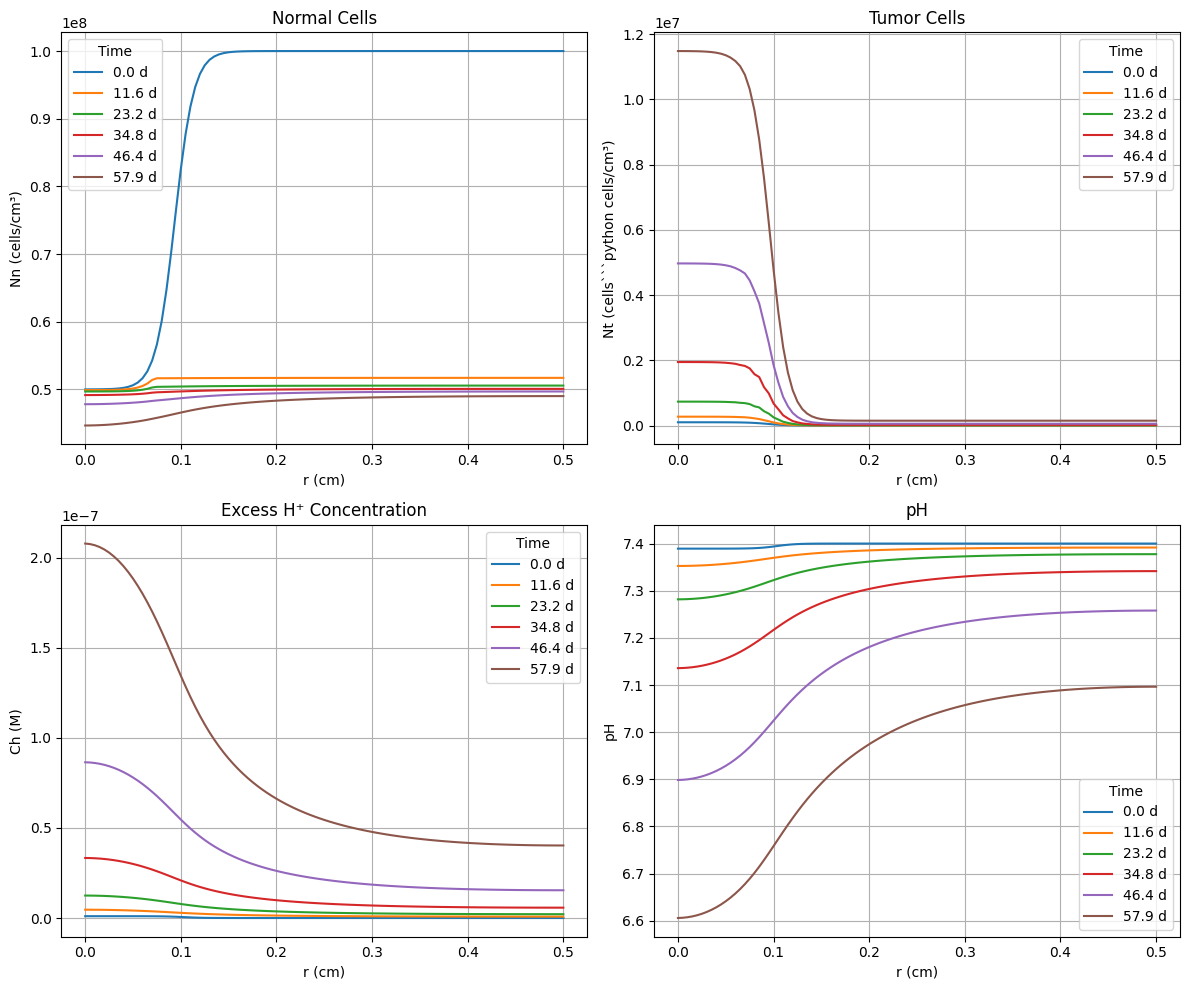

In [8]:
# Display Output
display(df)

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
for t in output_times:
    df_t = df[np.isclose(df['t'], t, atol=dt)]

    if not df_t.empty:
        plt.plot(df_t['r'], df_t['N_n'], label=f'{t / (3600*24):.1f} d')

plt.xlabel('r (cm)')
plt.ylabel('Nn (cells/cm³)')
plt.title('Normal Cells')
plt.legend(title='Time')
plt.grid(True)

plt.subplot(2, 2, 2)
for t in output_times:
    df_t = df[np.isclose(df['t'], t, atol=dt)]

    if not df_t.empty:
        plt.plot(df_t['r'], df_t['N_t'], label=f'{t / (3600*24):.1f} d')

plt.xlabel('r (cm)')
plt.ylabel('Nt (cells```python cells/cm³)')
plt.title('Tumor Cells')
plt.legend(title='Time')
plt.grid(True)

plt.subplot(2, 2, 3)
for t in output_times:
    df_t = df[np.isclose(df['t'], t, atol=dt)]

    if not df_t.empty:
        plt.plot(df_t['r'], df_t['C_h'], label=f'{t / (3600*24):.1f} d')

plt.xlabel('r (cm)')
plt.ylabel('Ch (M)')
plt.title('Excess H⁺ Concentration')
plt.legend(title='Time')
plt.grid(True)

plt.subplot(2, 2, 4)
for t in output_times:
    df_t = df[np.isclose(df['t'], t, atol=dt)]

    if not df_t.empty:
        plt.plot(df_t['r'], df_t['pH'], label=f'{t / (3600*24):.1f} d')
        
plt.xlabel('r (cm)')
plt.ylabel('pH')
plt.title('pH')
plt.legend(title='Time')
plt.grid(True)

plt.tight_layout()
plt.show()